# COMP90051 Project 2

**Copyright statement:** This notebook is copyright University of Melbourne. 
It is licensed for the sole purpose of your assessment in COMP90051. 
You are not permitted to share or publish derived versions of this notebook, other than with COMP90051 staff for assessment.

***

The code block below imports the namespaces/functions/classes you may use in the project. 
Additional imports are not permitted.

In [1]:
# Do not edit. These are the only imports permitted.
import numpy as np
from abc import ABC, abstractmethod
import matplotlib.pyplot as plt

# Type annotations
from numpy import ndarray
from numpy.random import Generator
from typing import List, Optional, Tuple, Callable

from sklearn.linear_model import LogisticRegression  # for Part 4

The base `MAB` class below defines a common interface for a contextual multi-armed bandit. 
Your bandit implementations in Parts 1-4 should inherit from this class.

In [2]:
class MAB(ABC):
    """Base class for a contextual multi-armed bandit (MAB)
    
    Parameters
    ----------
    n_arms : int
        Number of arms.
        
    rng : Generator, optional
        A `Generator` used as an internal source of randomness. If None, a 
        default `Generator` will be constructed using `np.random.default_rng`.
    """
    def __init__(self, n_arms: int, rng: Optional[Generator] = None) -> None:
        if not n_arms >= 0:
            raise ValueError("`n_arms` must be non-negative")
        self.n_arms = n_arms
        self.rng = np.random.default_rng(rng)
    
    @abstractmethod
    def play(self, context: Optional[ndarray] = None) -> int:
        """Play a round
        
        Parameters
        ----------        
        context : float numpy.ndarray, shape (n_arms, n_dims), optional
            An array of context vectors presented to the MAB. The 0-th 
            axis indexes the arms, and the 1-st axis indexes the features.
            Non-contextual bandits accept a context of None.
        
        Returns
        -------
        arm : int
            Integer index of the arm played this round. Should be in the set 
            {0, ..., n_arms - 1}.
        """
    
    @abstractmethod
    def update(self, arm: int, reward: float, context: Optional[ndarray] = None) -> None:
        """Update the internal state of the MAB after a play
        
        Parameters
        ----------
        arm : int
            Integer index of the played arm in the set {0, ..., n_arms - 1}.
            
        reward : float
            Reward received from the arm.
        
        context : float numpy.ndarray, shape (n_arms, n_dims), optional
            An array of context vectors that was presented to the MAB. The 
            0-th axis indexes the arms, and the 1-st axis indexes the 
            features. Non-contextual bandits accept a context of None.
        """
        if arm >= self.n_arms or arm < 0:
            raise ValueError("`arm` must be in the range "
                             "[0, {}]".format(self.n_arms - 1))

The function below implements off-policy evaluation as described in Appendix A of the project spec. 
You should use it—along with the provided dataset—to evaluate the bandits in Parts 1-4.

In [3]:
def offline_eval(mab: MAB, arms: ndarray, rewards: ndarray, contexts: ndarray, 
                 n_rounds: Optional[int] = None) -> ndarray:
    """Offline evaluation of a multi-armed bandit
    
    Parameters
    ----------
    mab : instance of MAB
        MAB to evaluate.
    
    arms : int ndarray, shape (n_events,) 
        Array containing the history of pulled arms, represented as integer 
        indices in the set {0, ..., mab.n_arms}
    
    rewards : float ndarray, shape (n_events,)
        Array containing the history of rewards. If a reward is missing, it 
        should be represented by `np.nan`.
    
    contexts : float ndarray, shape (n_events, n_arms, n_dims)
        Array containing the history of contexts presented to the arms. 
        The 0-th axis indexes the events in the history, the 1-st axis 
        indexes the arms and the 2-nd axis indexed the features.
        
    n_rounds : int, optional
        Number of matching events to evaluate the MAB on. If None, 
        continue evaluating until the historical events are exhausted.
    
    Returns
    -------
    matching_rewards : ndarray
        Rewards of matched events.
    """
    # Check types
    if not isinstance(mab, MAB):
        raise TypeError("`mab` must be an instance of MAB")
    arms = np.asarray(arms)
    rewards = np.asarray(rewards)
    contexts = np.asarray(contexts)
    if n_rounds is not None and n_rounds < 0:
        raise ValueError("`n_rounds` must be non-negative")
    
    # Check array dimensions
    if arms.ndim != 1:
        raise ValueError("`arms` must be a 1D array")
    if rewards.ndim != 1:
        raise ValueError("`rewards` must be a 1D array")
    if contexts.ndim != 3:
        raise ValueError("`contexts` must be a 3D array")
    if not (arms.shape[0] == rewards.shape[0] == contexts.shape[0]):
        raise ValueError("first dimension of input arrays are inconsistent")
    if contexts.shape[1] != mab.n_arms:
        raise ValueError("`contexts` has inconsistent second dimension")
    if arms.max() >= mab.n_arms or arms.min() < 0:
        raise ValueError("`arms` contains ids that are out-of-range")
    
    matched_ctr = 0
    matched_ids = list()
    for i in range(arms.size):
        if n_rounds is not None and matched_ctr >= n_rounds: # Note: fixed
            break
        arm_id = mab.play(contexts[i])
        if arm_id == arms[i]:
            reward = None if np.isnan(rewards[i]) else rewards[i]
            mab.update(arm_id, reward, contexts[i])
            matched_ctr += 1
            matched_ids.append(i)
    
    return rewards[matched_ids], matched_ids

Please define any static functions/variables (used across multiple tasks) in the code block below.

In [4]:
rng = np.random.default_rng(90051)  # Random generator used throughout

# Define additional static functions/variables here, if required

# plot the per-round cumulative reward: Code from tutorial notebook
def plot_results(results: list, label: Optional[str] = None):
    tround = np.arange(1, results.size + 1)
    cumsum = np.cumsum(results)/tround
    plt.plot(tround, cumsum, label=label)

# Argmax with ties broken uniformly at random
def argmax_rand(x: ndarray, rng: Generator):
    return rng.choice(np.flatnonzero(x == x.max()))

# Argmin with ties broken uniformly at random
def argmin_rand(x: ndarray, rng: Generator):
    return rng.choice(np.flatnonzero(x == x.min()))

# Compute policy value for Part 3
def policy_fn(mu: ndarray, c: float):
    mu = mu.astype(np.float128)
    # if c*mu>11356, it will cause the overflow in exp() function, return max in this case
    if any(c*mu>11356):
        return (mu==max(mu)).astype(np.float64)
    res = np.exp(c*mu)/sum(np.exp(c*mu))
    res = res.astype(np.float64)
    return res
    

## Part 1: Thompson sampling MAB

In [5]:
class TS(MAB):
    """Thompson sampling MAB with a Beta-Bernoulli reward model

    Parameters
    ----------
    n_arms : int
        Number of arms.

    alpha0: float, optional
        positive real prior hyperparameter

    beta0: float, optional
        positive real prior hyperparameter
    
    rng : Generator, optional
        A `Generator` used as an internal source of randomness. If None, a 
        default `Generator` will be constructed using `np.random.default_rng`.
    """
    def __init__(self, n_arms: int, alpha0: float = 1.0, beta0: float = 1.0, 
                 rng: Optional[Generator] = None) -> None:
        # the alpha and beta should be positive number
        super().__init__(n_arms, rng)
        if alpha0 < 0 or beta0 < 0:
            raise ValueError("`alpha0` and `beta0` must be positive")
        self.alphas = np.full(n_arms, alpha0)
        self.betas = np.full(n_arms, beta0)
        
    def play(self, context: Optional[ndarray] = None) -> int:
        # sample from beta(alpha+1, beta+1) distribution
        self.sampled = self.rng.beta(self.alphas+1, self.betas+1, self.n_arms)
        return argmax_rand(self.sampled, self.rng)
    
    def update(self, arm: int, reward: float, context: Optional[ndarray] = None) -> None:
        super().update(arm, reward, context)
        # TS works for binary reward
        if reward != 0 and reward != 1:
            raise ValueError("`reward` must be either 0 or 1")
        # update parameters for beta distribution
        if reward == 0:
            self.betas[arm] += 1
        elif reward == 1:
            self.alphas[arm] += 1

In [6]:
# Load dataset here
dataset = np.genfromtxt('dataset.txt', dtype=np.int64)

# dataset where column 1 forms arms, column 2 forms rewards, and columns 3–102 form contexts
arms = dataset[:,0] 
rewards = dataset[:,1].astype(float)
contexts = dataset[:,2::].astype(float).reshape(-1,10,10) 

In [7]:
mab = TS(10, alpha0=1.0, beta0=1.0, rng=rng)
TS_rewards, TS_ids = offline_eval(mab, arms, rewards, contexts, n_rounds=800)
print('TS average reward', np.mean(TS_rewards))

TS average reward 0.215


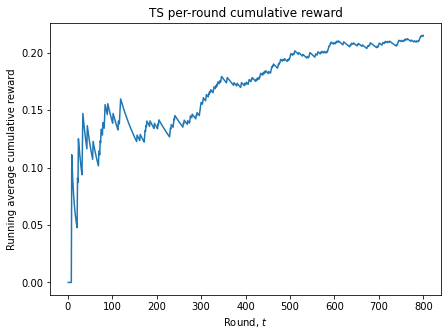

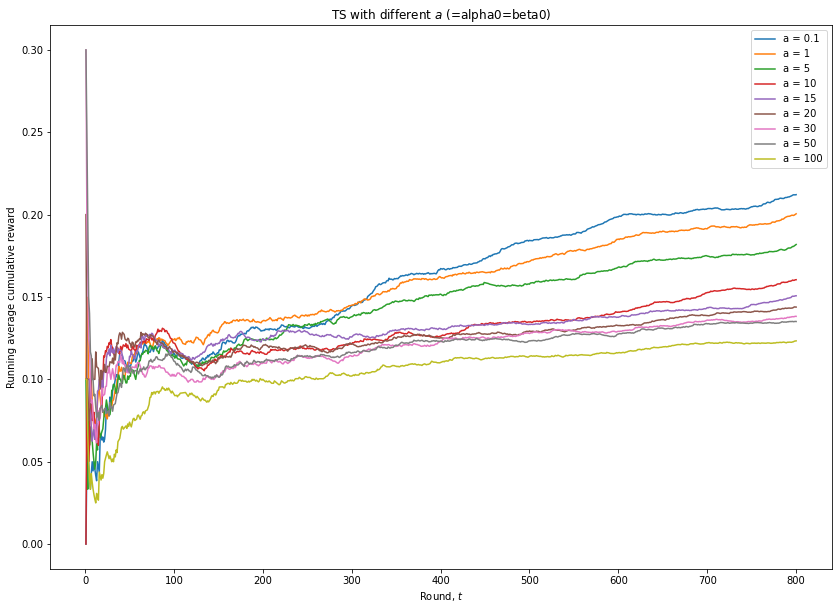

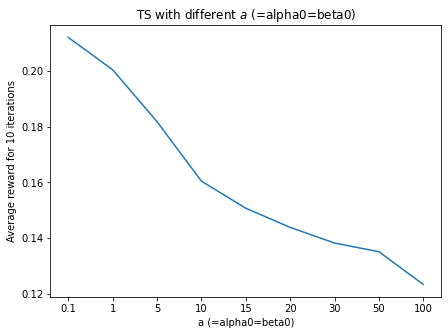

- From two plots shown above, the smaller values for a (=alpha0=beta0) tend to have better performance.
- The optimal value for a is equal to 0.1 in our testing example.


In [8]:
# Use additional cells here for experimentation

# b) Run offline evaluation as above, but now plot the per-round cumulative reward
plt.figure(figsize=(7,5))
plot_results(TS_rewards)
plt.xlabel('Round, $t$')
plt.ylabel('Running average cumulative reward')
plt.title("TS per-round cumulative reward")
plt.show()


# c) Devise and run a grid-search based strategy to select alpha0 and beta0 for TS as Python code

plt.figure(figsize=(14,10))

# candidates contains different value of a (=alpha0 = beta0)
candidates = [0.1, 1,5,10,15,20,30,50,100]

# results save the average reward for 10 iterations 
results = []
for a in candidates:
    temp = []
    for iter in range(10):
        mab = TS(10, alpha0=a, beta0=a, rng=rng)
        new_TS_rewards, _ = offline_eval(mab, arms, rewards, contexts, n_rounds=800)
        temp.append(new_TS_rewards)
    results.append(np.mean(temp))
    plot_results(np.mean(temp,axis=0), label="a = "+ str(a))

plt.legend()
plt.xlabel('Round, $t$')
plt.ylabel('Running average cumulative reward')
plt.title("TS with different $a$ (=alpha0=beta0)")
plt.show()


plt.figure(figsize=(7,5))

# plot the average reward for 10 iterations with different a value
xs = [str(i) for i in candidates]
plt.plot(xs, results)
plt.xlabel('a (=alpha0=beta0)')
plt.ylabel('Average reward for 10 iterations')
plt.title('TS with different $a$ (=alpha0=beta0)')
plt.show()

print("- From two plots shown above, the smaller values for a (=alpha0=beta0) tend to have better performance.")
print("- The optimal value for a is equal to 0.1 in our testing example.")

## Part 2: Thompson sampling contextual MAB with linear payoffs

In [9]:
class LinTS(MAB):
    """Thompson sampling contextual MAB with a ridge regression reward model

    Parameters
    ----------
    n_arms : int
        Number of arms.
    
    n_dims : int
        Number of dimensions for each arm's context.
        
    v: float, optional
        Positive real explore-exploit parameter
    
    rng : Generator, optional
        A `Generator` used as an internal source of randomness. If None, a 
        default `Generator` will be constructed using `np.random.default_rng`.
    """    
    def __init__(self, n_arms: int, n_dims: int, v: float = 1.0, 
                 rng: Optional[Generator] = None) -> None:
        super().__init__(n_arms, rng)
        if v <= 0:
            raise ValueError("`v` must be positive")
        self.mu = np.zeros(n_dims)
        self.f = np.zeros(n_dims)
        self.B = np.identity(n_dims)
        self.n_dims = n_dims
        self.v = v
        
    def play(self, context: Optional[ndarray] = None) -> int:
        # sample mu_tilda from normal distribution
        self.mu_tilde = rng.multivariate_normal(self.mu, np.linalg.inv(self.B)*self.v**2)
        return argmax_rand(context @ self.mu_tilde.T, self.rng)
    
    def update(self, arm: int, reward: float, context: Optional[ndarray] = None) -> None:
        super().update(arm, reward, context)
        
        # update parameters for normal distribution
        b_t = context[arm].reshape((self.n_dims,1))
        self.B += b_t @ b_t.T
        self.f += context[arm] * reward
        self.mu = np.linalg.inv(self.B) @ self.f

In [10]:
mab = LinTS(10, 10, v=1.0, rng=rng)
LinTS_rewards, LinTS_ids = offline_eval(mab, arms, rewards, contexts, n_rounds=800)
print('LinTS average reward', np.mean(LinTS_rewards))

LinTS average reward 0.30375


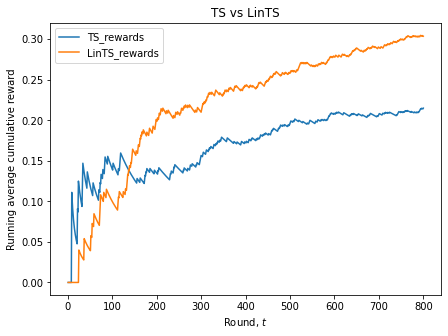

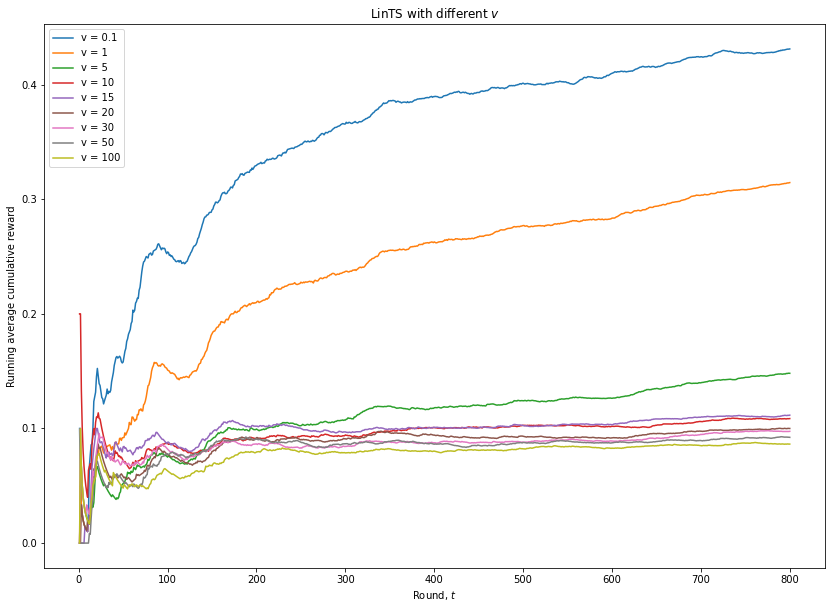

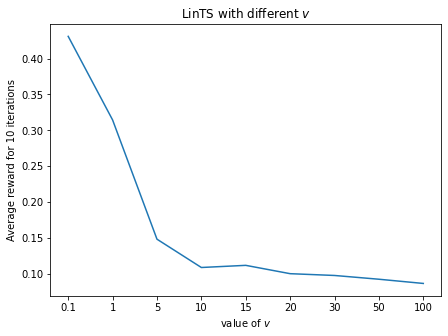

- From two plots shown above, higher v value will cause the reduction in the performance
- The optimal value for v is equal to 0.1


In [11]:
# Use additional cells here for experimentation

# b) Plot the per-round cumulative reward for TS and LinTS on the same set of axes.
plt.figure(figsize=(7,5))

plot_results(TS_rewards, "TS_rewards")
plot_results(LinTS_rewards, "LinTS_rewards")

plt.legend()
plt.xlabel('Round, $t$')
plt.ylabel('Running average cumulative reward')
plt.title("TS vs LinTS")
plt.show()
# c) This time consider tuning v.
plt.figure(figsize=(14,10))

# candidates contains different value of v 
candidates = [0.1, 1,5,10,15,20,30,50,100]

# results save the average reward in 10 iterations
results = []
for v in candidates:
    temp = []
    for iter in range(10):
        mab = LinTS(10, 10, v=v, rng=rng)
        new_LinTS_rewards, _ = offline_eval(mab, arms, rewards, contexts, n_rounds=800)
        temp.append(new_LinTS_rewards)
    results.append(np.mean(temp))
    plot_results(np.mean(temp,axis=0), label="v = "+ str(v))

plt.legend()
plt.xlabel('Round, $t$')
plt.ylabel('Running average cumulative reward')
plt.title("LinTS with different $v$")
plt.show()


plt.figure(figsize=(7,5))

# plot the average reward for 10 iterations with different v value
xs = [str(i) for i in candidates]
plt.plot(xs, results)
plt.xlabel('value of $v$')
plt.ylabel('Average reward for 10 iterations')
plt.title('LinTS with different $v$')
plt.show()

print("- From two plots shown above, higher v value will cause the reduction in the performance")
print("- The optimal value for v is equal to 0.1")


## Part 3: Thompson sampling MABs with fair exposure

In [12]:
class FairXTS(TS):
    """FairX Thompson sampling MAB with a Beta-Bernoulli reward model

    Parameters
    ----------
    n_arms : int
        Number of arms.

    c : float, optional
        Scaling factor for expected reward in exponential merit function
    
    alpha0: float, optional
        Positive real prior hyperparameter.

    beta0: float, optional
        Positive real prior hyperparameter.
    
    rng : Generator, optional
        A `Generator` used as an internal source of randomness. If None, a 
        default `Generator` will be constructed using `np.random.default_rng`.
    """
    def __init__(self, n_arms: int, c: float = 1.0, alpha0: float = 1.0, 
                 beta0: float = 1.0, rng: Optional[Generator] = None) -> None:
        super().__init__(n_arms, alpha0, beta0, rng)
        self.c = c
    
    def play(self, context: Optional[ndarray] = None) -> int:
        super().play(context)
        
        # calculate policy 
        policy = policy_fn(self.sampled, self.c)
        
        # randomly select an arm from the distribution
        return self.rng.choice(self.n_arms, p=policy)
    

In [13]:
mab = FairXTS(10, c=1.0, alpha0=1.0, beta0=1.0, rng=rng)
FairXTS_rewards, FairXTS_ids = offline_eval(mab, arms, rewards, contexts, n_rounds=800)
print('FairX-TS average reward', np.mean(FairXTS_rewards))

FairX-TS average reward 0.10875


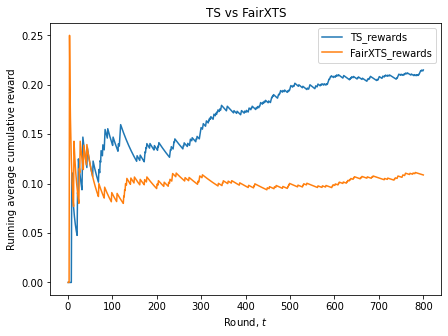

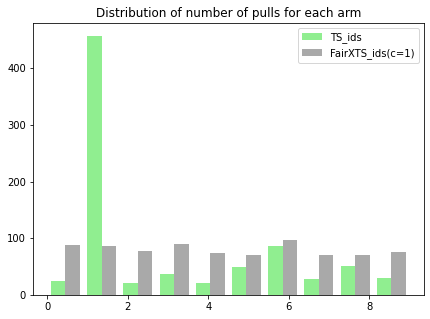

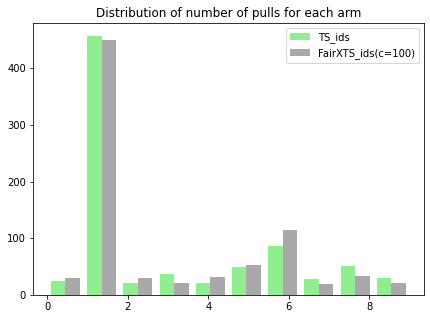

- From two plots above, we can see the MAB with fair exposure have equally distributed number of pulls for each arm
- the higher value of c will be more like the original TS MAB and tend to focus on one specific arm


In [14]:
# Use additional cells here for experimentation

# b) Plot the per-round cumulative reward for TS and FairXTS on the same set of axes.
plt.figure(figsize=(7,5))
plot_results(TS_rewards, "TS_rewards")
plot_results(FairXTS_rewards, "FairXTS_rewards")

plt.legend()
plt.xlabel('Round, $t$')
plt.ylabel('Running average cumulative reward')
plt.title("TS vs FairXTS")
plt.show()

# c) Plot the number of pulls for each arm for TS and FairXTS and comment on any differences you observe
plt.figure(figsize=(7,5))
plt.hist([arms[TS_ids],arms[FairXTS_ids]], label=['TS_ids','FairXTS_ids(c=1)'], color=['lightgreen','darkgrey'])
plt.legend(loc='upper right')
plt.title("Distribution of number of pulls for each arm")
plt.show()

plt.figure(figsize=(7,5))
new_mab = FairXTS(10, c=100.0, alpha0=1.0, beta0=1.0, rng=rng)
new_FairXTS_rewards, new_FairXTS_ids = offline_eval(new_mab, arms, rewards, contexts, n_rounds=800)

plt.hist([arms[TS_ids],arms[new_FairXTS_ids]], label=['TS_ids','FairXTS_ids(c=100)'], color=['lightgreen','darkgrey'])
plt.legend(loc='upper right')
plt.title("Distribution of number of pulls for each arm")
plt.show()
print("- From two plots above, we can see the MAB with fair exposure have equally distributed number of pulls for each arm")
print("- the higher value of c will be more like the original TS MAB and tend to focus on one specific arm")


In [15]:
class FairXLinTS(LinTS):
    """FairX Thompson sampling contextual MAB with a ridge regression reward model

    Parameters
    ----------
    n_arms : int
        Number of arms.
    
    n_dims : int
        Number of dimensions for each arm's context.
    
    c : float, optional
        Scaling factor for expected reward in exponential merit function
    
    v: float, optional
        Positive real explore-exploit parameter
    
    rng : Generator, optional
        A `Generator` used as an internal source of randomness. If None, a 
        default `Generator` will be constructed using `np.random.default_rng`.
    """
    def __init__(self, n_arms: int, n_dims: int, c: float = 1.0, 
                 v: float = 1.0, rng: Optional[Generator] = None) -> None:
        super().__init__(n_arms,n_dims, v, rng)
        self.c = c
    
    def play(self, context: Optional[ndarray] = None) -> int:
        super().play(context)
        # calculate policy 
        policy = policy_fn(context @ self.mu_tilde.T, self.c)
        # randomly select an arm from the distribution
        return self.rng.choice(self.n_arms, p=policy)
    
    

In [16]:
mab = FairXLinTS(10, 10, c=1.0, v=1.0, rng=rng)
FairXLinTS_rewards, FairXLinTS_ids = offline_eval(mab, arms, rewards, contexts, n_rounds=800)
print('FairX-LinTS average reward', np.mean(FairXLinTS_rewards))

FairX-LinTS average reward 0.12


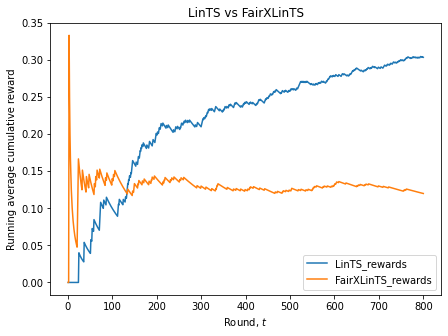

In [17]:
# Use additional cells here for experimentation
# e) Plot the per-round cumulative reward for LinTS and FairXLinTS on the same set of axes.
plt.figure(figsize=(7,5))
plot_results(LinTS_rewards, "LinTS_rewards")
plot_results(FairXLinTS_rewards, "FairXLinTS_rewards")

plt.legend()
plt.xlabel('Round, $t$')
plt.ylabel('Running average cumulative reward')
plt.title("LinTS vs FairXLinTS")
plt.show()


## Task 4: SquareCB contextual MAB with a logistic regression oracle

In [18]:
class SquareCB(MAB):
    """SquareCB contextual MAB with a logistic regression oracle

    Parameters
    ----------
    n_arms : int
        Number of arms.

    n_dims : int
        Number of features for each arm's context.
    
    gamma : float, optional
        Learning rate parameter.
    
    rng : Generator, optional
        A `Generator` used as an internal source of randomness. If None, a 
        default `Generator` will be constructed using `np.random.default_rng`.
    """
    def __init__(self, n_arms: int, n_dims: int, gamma: float = 1.0, 
                 rng: Optional[Generator] = None) -> None:
        super().__init__(n_arms, rng)
        
        # the gamma should be positive number
        if gamma <= 0:
            raise ValueError("`gamma` must be positive")
        
        self.gamma = gamma
        self.mu = n_arms # mu is set to equal to number of arms
        self.models = [LogisticRegression() for i in range(n_arms)]
        
        # history_X and history_y records the historical context and reward data for different arms
        self.history_X = {} 
        self.history_y = {}
    
    def play(self, context: Optional[ndarray] = None) -> int:
        # y_hat records the predicted prob from context data for different arms using LR if successful, else set to 0
        y_hat = []
        for model, con in zip(self.models, context):
            try:
                y_hat.append(model.predict_proba(con.reshape(1,-1))[0][-1])
            except:
                y_hat.append(np.NaN)
        y_hat = np.nan_to_num(y_hat, nan=0)
        
        # b_t_ind and b_t_val are the index and value of min element in y_hat
        b_t_ind = argmin_rand(y_hat, self.rng) 
        b_t_val = y_hat[b_t_ind]
        
        # calculate the probability for each arm
        probs = 1/(self.mu+self.gamma*(y_hat-y_hat[b_t_ind]))
        probs[b_t_ind] = 1-sum(probs[:b_t_ind])-sum(probs[b_t_ind+1:])
        
        # randomly select an arm from distribution
        return self.rng.choice(self.n_arms, p=probs)
    
    def update(self, arm: int, reward: float, 
               context: Optional[ndarray] = None) -> None:
        super().update(arm, reward, context)
        
        # loss is set to the negative of reward
        loss = -1 * reward
        
        # save the context to historical data
        self.history_X[arm] = np.vstack((self.history_X[arm], context[arm])) if arm in self.history_X else context[arm]
        self.history_y[arm] = np.append(self.history_y[arm], loss) if arm in self.history_y else np.array(loss)
        
        # fit model if the data is valid
        try:
            self.models[arm] = self.models[arm].fit(self.history_X[arm], self.history_y[arm])
        except:
            pass

In [19]:
mab = SquareCB(10, 10, gamma=18.0, rng=rng)
SquareCB_rewards, SquareCB_ids = offline_eval(mab, arms, rewards, contexts, n_rounds=800)
print('SquareCB average reward', np.mean(SquareCB_rewards))

SquareCB average reward 0.32375


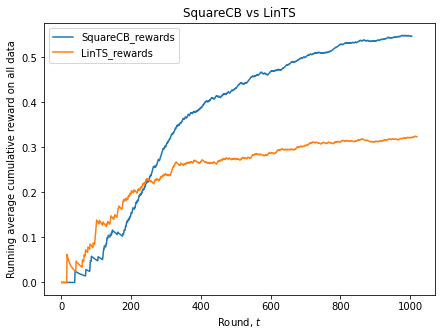

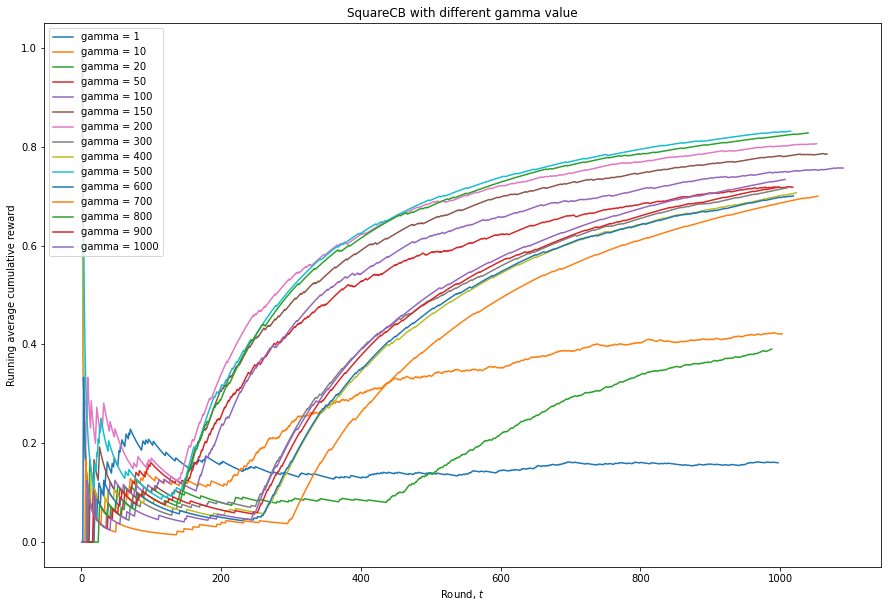

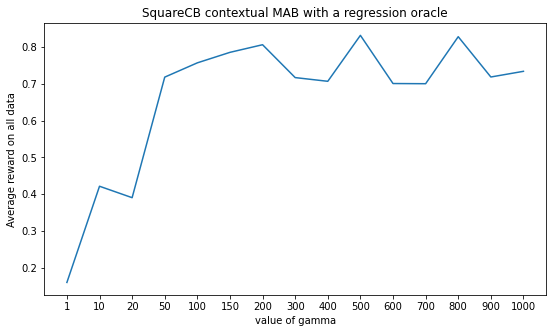

- From two plots above, we can see that the performance of MAB can increase with larger gamma value at first, after the gamma value equals to 200, the performance has fluctuated on higher gamma value.
- Therefore the opimal gamma value here is 200. The best average reward is around 0.80


In [20]:
# Use additional cells here for experimentation

# b) When plotting the results on all data, include LinTS’s curve too.
plt.figure(figsize=(7,5))
mab = LinTS(10, 10, v=1.0, rng=rng)
LinTS_rewards, LinTS_ids = offline_eval(mab, arms, rewards, contexts)
mab = SquareCB(10, 10, gamma=18.0, rng=rng)
SquareCB_rewards, SquareCB_ids = offline_eval(mab, arms, rewards, contexts)

plot_results(SquareCB_rewards, "SquareCB_rewards")
plot_results(LinTS_rewards, "LinTS_rewards")

plt.legend()
plt.xlabel('Round, $t$')
plt.ylabel('Running average cumulative reward on all data')
plt.title("SquareCB vs LinTS")
plt.show()


# c) This time consider tuning gamma
plt.figure(figsize=(15,10))

# candidates contains different value of gamma 
candidates = [1, 10, 20, 50, 100, 150, 200, 300, 400, 500, 600, 700, 800, 900, 1000]

# results save the average reward 
results = []
for a in candidates:
    mab = SquareCB(10, 10, gamma=a, rng=rng)
    SquareCB_rewards, SquareCB_ids = offline_eval(mab, arms, rewards, contexts)
    results.append(np.mean(SquareCB_rewards))
    plot_results(SquareCB_rewards, label="gamma = "+ str(a))

plt.legend()
plt.xlabel('Round, $t$')
plt.ylabel('Running average cumulative reward')
plt.title("SquareCB with different gamma value")
plt.show()



plt.figure(figsize=(9,5))

# plot the average reward with different gamma value
xs = [str(i) for i in candidates]
plt.plot(xs, results)
plt.xlabel('value of gamma')
plt.ylabel('Average reward on all data')
plt.title('SquareCB contextual MAB with a regression oracle')
plt.show()

print("- From two plots above, we can see that the performance of MAB can increase with larger gamma value at first, after the gamma value equals to 200, the performance has fluctuated on higher gamma value.")
print("- Therefore the opimal gamma value here is 200. The best average reward is around 0.80")


      